In [1]:
import cv2
import imagehash
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Resize the image
    img = cv2.resize(img, (64, 64))

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply a slight blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Histogram equalization
    equalized = cv2.equalizeHist(blurred)

    # Normalize pixel values
    normalized = equalized / 255.0

    return normalized

In [3]:
def dhash(image, hash_size=8):
    # Resize the image based on hash size
    image = cv2.resize(image, (hash_size + 1, hash_size))
    diff = image[:, 1:] > image[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [4]:
def perceptual_hash(image):
    # Preprocess the image
    processed_image = preprocess_image(image)

    # Create a pHash using imagehash library
    hash_value = imagehash.phash(Image.fromarray((processed_image * 255).astype('uint8')))
    
    return hash_value

In [5]:
def find_duplicates_dhash(folder_path, threshold=10): # NEED TO EXPERIMENT WITH THE THRESHHOLD VALUE
    hash_dict = {}
    duplicate_groups = {}

    for image_path in Path(folder_path).glob('*.*'):
        if image_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            # Preprocess the image
            processed_image = preprocess_image(str(image_path))

            # Compute the dHash
            hash_value = dhash(processed_image)

            # Check for near-duplicates within a threshold
            for existing_hash, existing_image_paths in hash_dict.items():
                if np.abs(hash_value - existing_hash) < threshold:
                    existing_image_paths.append(image_path)
                    duplicate_groups[hash_value] = existing_image_paths

            # Add the current image to the hash dictionary
            hash_dict[hash_value] = [image_path]

    return duplicate_groups

In [6]:
def find_duplicates_phash(folder_path, threshold=5): # NEED TO EXPERIMENT WITH THE THRESHHOLD VALUE
    hash_dict = {}
    duplicate_groups = {}

    for image_path in Path(folder_path).glob('*.*'):
        if image_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            hash_value = perceptual_hash(str(image_path))

            # Check for near-duplicates within a threshold
            for existing_hash, existing_image_paths in hash_dict.items():
                if hash_value - existing_hash < threshold:
                    existing_image_paths.append(image_path)
                    duplicate_groups[hash_value] = existing_image_paths

            hash_dict[hash_value] = [image_path]

    return duplicate_groups

In [7]:
def display_all_duplicate_images(duplicate_groups):
    for hash_value, image_paths in duplicate_groups.items():
        num_images = len(image_paths)

        plt.figure(figsize=(5 * num_images, 5))
        for i, image_path in enumerate(image_paths, 1):
            img = cv2.imread(str(image_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_images, i)
            plt.imshow(img)
            plt.title(f'Image {i}: {image_path.name}')

        plt.show()
        
    print(f'Found {len(duplicate_groups)} groups of duplicate images')

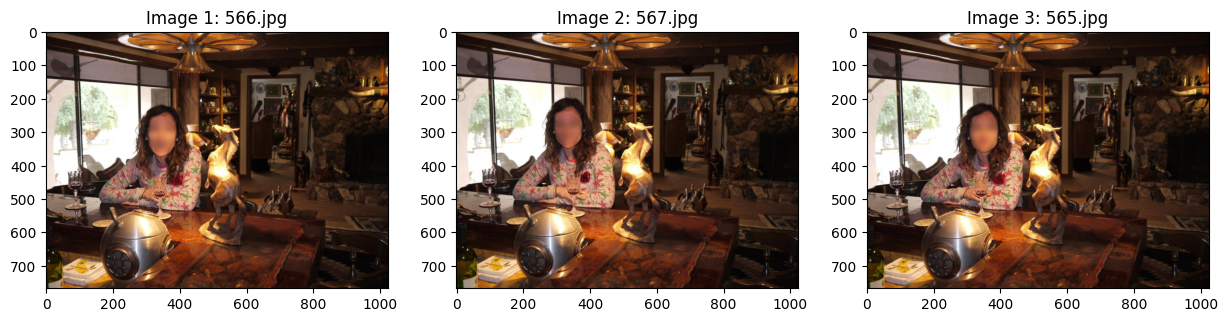

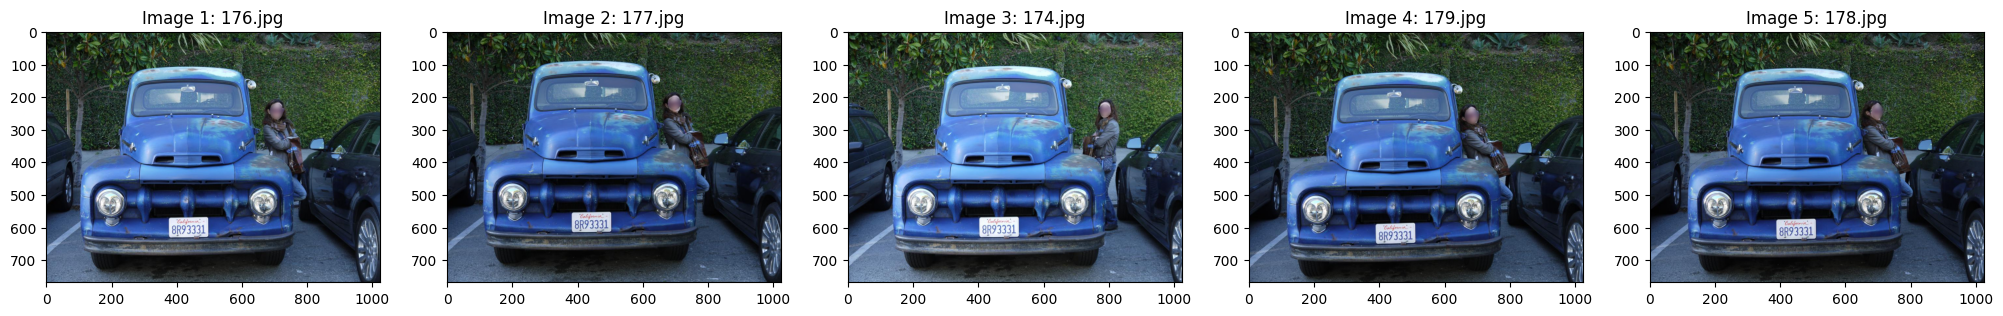

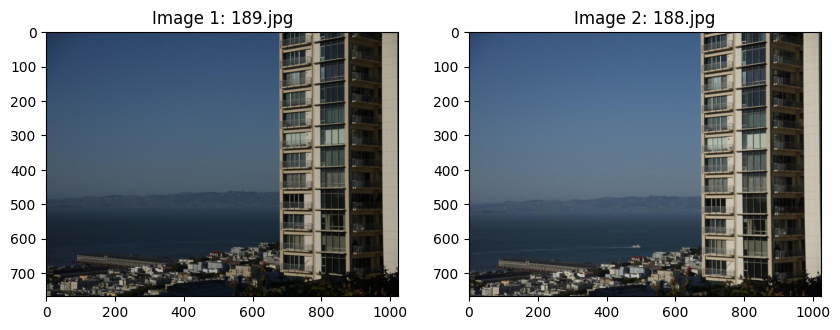

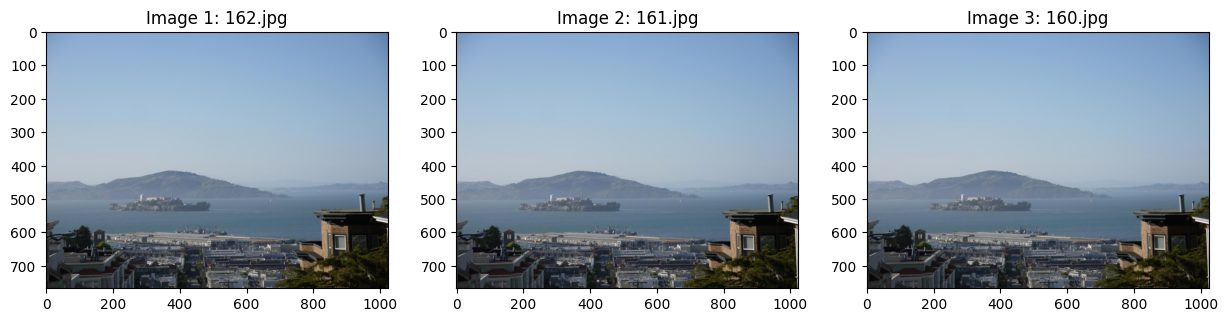

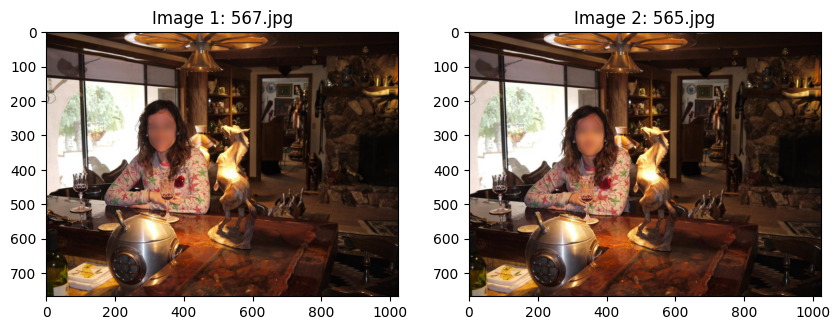

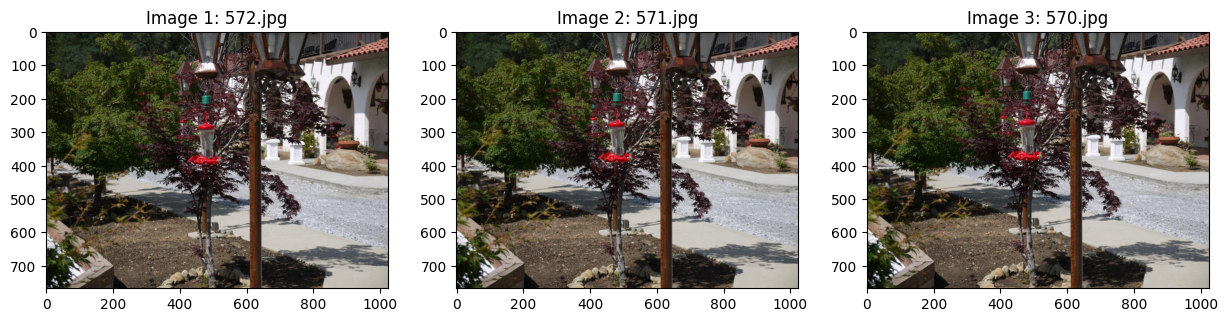

KeyboardInterrupt: 

In [8]:
if __name__ == "__main__":
    folder_path = "../California/Photos"
    duplicate_pairs = find_duplicates_phash(folder_path)

    if duplicate_pairs:
        display_all_duplicate_images(duplicate_pairs)
    else:
        print("No duplicate images found.")